
# Spatial Gene Expression Reconstruction using ZENomix (Zebrafish Example; MZoep mutant)

This notebook walks through how to reconstruct spatial gene expression using **ZenoMix**.

We will:
1. Load scRNA-seq & spatial reference data
2. Build a ZENomix model
3. Calibrate latent variables
4. Reconstruct gene expression
5. Visualize expression & uncertainty for a gene of interest (example: `TA`)



## 1. Setup and installation

Required packages:
- `numpy`
- `pandas`
- `matplotlib`
- `jax`
- `zenomix`

Optional installation command:

```bash
pip install numpy pandas matplotlib jax zenomix
```



## 2. Import libraries and verify JAX backend

We import ZenoMix and verify whether JAX is using CPU or GPU.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zenomix as zg

# Verify JAX backend (CPU/GPU)
import jax
jax.default_backend()


/data1/okochi/miniconda3/envs/zenomix/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'gpu'


## 3. Load input data

- `data_Mutant`: expression matrix (genes × spots/cells)
- `reference`: spatial reference (e.g., in situ hybridization)
- `geometry`: spatial pseudo-coordinates (x/y/z or similar)

> Update file paths to match your environment.


In [ ]:
DATA_MUTANT_PATH = "YourPath/MZoep_scRNAseq_sample.txt"
REFERENCE_PATH   = "YourPath/WT_ISH_sample.txt"
GEOMETRY_PATH    = "YourPath/geometry_sample.tsv"

data_Mutant = pd.read_csv(DATA_MUTANT_PATH, sep="\t", index_col=0)
reference   = pd.read_csv(REFERENCE_PATH, sep="\t")
geometry    = pd.read_csv(GEOMETRY_PATH, sep="\t")

print("data_Mutant:", data_Mutant.shape)
print("reference:", reference.shape)
print("geometry:", geometry.shape)

display(data_Mutant.head())
display(reference.head())
display(geometry.head())


data_Mutant: (325, 26545)
reference: (64, 47)
geometry: (64, 6)


,7SK,A1CF,A2M,A2ML,A2ML1,AAAS,AACS,AADACL4,AADAT,AAED1,...,ZGC:153522,ZGC:153615,ZGC:165555,ZGC:171951,ZGC:172053,ZGC:172109,ZGC:174355,ZGC:174710,ZGC:194948,ZGC:195175
oep_p0_S10,0.0,0.0,0.0,2.703083,2.703083,0.000000,2.703083,0.0,2.703083,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oep_p0_S11,0.0,0.0,0.0,4.398614,4.398614,2.752862,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oep_p0_S12,0.0,0.0,0.0,1.530518,1.530518,0.000000,1.530518,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oep_p0_S13,0.0,0.0,0.0,4.006084,4.006084,2.253053,4.006084,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oep_p0_S14,0.0,0.0,0.0,2.643896,2.643896,3.000041,0.000000,0.0,4.339895,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ADMP,APLNRB,AXIN2,BAMBIA,BMP2B,BMP4,BMP7A,CDX4,CHD,CST3,...,SP5L,SZL,TA,TBX16,TPH1B,VED,VENT,VOX,WNT8A,WNT11
1,0,0,0,1,1,1,1,0,0,0,...,0,1,0,0,0,1,1,1,0,0
2,0,0,0,1,1,1,1,0,0,0,...,0,1,0,0,0,1,1,1,0,0
3,0,0,0,1,1,1,1,0,0,0,...,1,1,0,0,0,1,1,1,0,0
4,0,0,1,1,1,1,1,0,0,0,...,1,1,0,0,0,1,1,1,0,0
5,0,0,1,1,1,1,1,1,0,0,...,1,1,1,1,0,1,1,1,0,0


,bin,tier,dv,x,y,z
0,1,24-30,1-4,0.038010,-0.151746,0.987688
1,2,17-23,1-4,0.121490,-0.485016,0.866025
2,3,13-16,1-4,0.176252,-0.703636,0.688355
3,4,9-12,1-4,0.207175,-0.827088,0.522499
4,5,7-8,1-4,0.224484,-0.896192,0.382683



## 4. Build and calibrate the ZENomix model

- `latent_dim` controls the number of latent dimensions (10–50 is typical).
- `latent_calibration()` optimizes the latent space.


In [3]:
%%time
model = zg.Model(
    data=data_Mutant,
    reference=reference,
    latent_dim=20,      # latent dimension
    num_inducing=50     # number of inducing points (empirically important for performance, see sensitivity analysis of our paper)
)

model.latent_calibration(method="lbfgs")

2026-02-18 12:14:25.946295: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2026-02-18 12:14:26.789454: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


  MMD = 0.001638
CPU times: user 4min 52s, sys: 7.59 s, total: 5min
Wall time: 40.9 s



## 5. Reconstruct spatial expression

After calibration, we compute reconstructed expression values.



In [4]:

res = model.reconstruction()
display(res.head())


,7SK,A1CF,A2M,A2ML,A2ML1,AAAS,AACS,AADACL4,AADAT,AAED1,...,ZGC:153522,ZGC:153615,ZGC:165555,ZGC:171951,ZGC:172053,ZGC:172109,ZGC:174355,ZGC:174710,ZGC:194948,ZGC:195175
1,0.0,0.080973,0.495709,0.769867,2.114122,0.601424,0.755580,0.007366,1.615241,0.407147,...,0.002214,0.047734,1.197972,0.006270,0.084436,0.013201,-0.018860,0.001604,0.030620,0.000468
2,0.0,0.080973,0.495709,0.769867,2.114122,0.601424,0.755580,0.007366,1.615241,0.407147,...,0.002214,0.047734,1.197972,0.006270,0.084436,0.013201,-0.018860,0.001604,0.030620,0.000468
3,0.0,0.039952,0.529715,1.100038,2.215497,0.658634,0.782972,0.014511,1.696037,0.322896,...,0.004663,0.068399,0.999898,0.008293,0.101343,0.018565,-0.017815,-0.000311,0.033504,-0.000420
4,0.0,0.041706,0.536241,1.243138,2.276215,0.637869,0.768527,0.016303,1.644752,0.286722,...,0.006309,0.074277,0.984954,0.008273,0.094768,0.019149,-0.011954,0.000192,0.037402,-0.000146
5,0.0,0.004457,0.827197,1.703387,2.428877,0.601561,0.892590,0.018995,1.489401,0.200040,...,0.004631,0.049973,1.221552,0.002998,0.090815,0.006822,0.051309,0.016196,0.008803,0.006182



## 6. Visualize spatial expression of a gene

Example gene: `TA`.

We clip values at the 1%–99% quantile of expressions of all genes to show absolute expression levels.


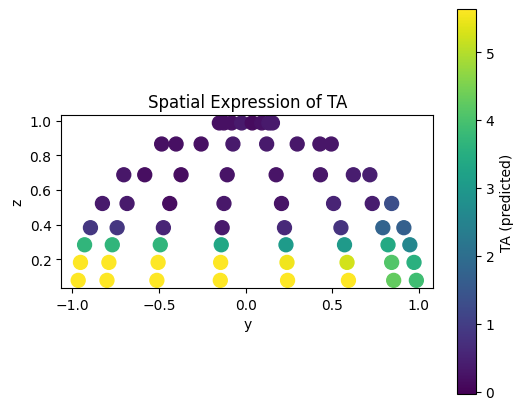

In [5]:

gene_of_interest = "TA"
vmin = np.quantile(res.values, 0.01)
vmax = np.quantile(res.values, 0.99)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    geometry["y"], geometry["z"],
    c=res[gene_of_interest],
    cmap="viridis",
    vmin=vmin, vmax=vmax,
    s=100
)
plt.colorbar(scatter, label=f"{gene_of_interest} (predicted)")
plt.xlabel("y")
plt.ylabel("z")
plt.title(f"Spatial Expression of {gene_of_interest}")
plt.gca().set_aspect('equal')
plt.show()



## 7. Calculate prediction uncertainty

ZenoMix returns uncertainty (variance/covariance) per gene using `cov_gene()`.



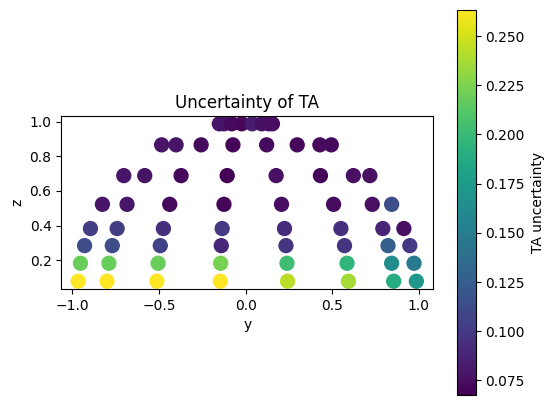

In [6]:

cov = model.cov_gene(gene_of_interest)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    geometry["y"], geometry["z"],
    c=cov,
    cmap="viridis",
    s=100
)
plt.colorbar(scatter, label=f"{gene_of_interest} uncertainty")
plt.xlabel("y")
plt.ylabel("z")
plt.title(f"Uncertainty of {gene_of_interest}")
plt.gca().set_aspect('equal')
plt.show()



## 8. Tips and best practices

- Ensure ordering of `geometry` matches `reference` sample ordering.
- Avoid very large `latent_dim` and `num_inducing` initially.
- Save reconstruction: `res.to_csv("reconstruction.csv")`
- Gene name must exactly match column names in `res`.

---

### Minimal runnable example

```python
import zenomix as zg
model = zg.Model(data, reference, latent_dim=20)
model.latent_calibration()
res = model.reconstruction()
cov = model.cov_gene("TA")
```
